Super consejito del día: import modin.pandas as pd

# Lab: Explainability in Neural Networks with activation maximitation.


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

In this part of the lab, we will implement a simple example of **activation maximization** to find out wich patterns are neccesary at the input of a neural network, that has been previously trained, to get a desired output (for example, a high confidence in a classification task).

We will visualize this technique using MNIST database.

PRÁCTICA 2 PARTE 3 - REDES NEURONALES - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

JAVIER ROMERO GARCÍA - DNI: 49276810T

In [1]:
# En esta práctica realizaremos un ejemplo básico de "activation maximization". De esta forma encontraremos que tiene en cuenta nuestra red neuronal en las variables de entrada con el fin de clasificar a una clase u otra. 
# Haremos este ejemplo usando un MLP junto al dataset MNIST

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

# Importamos las librerías necesarias para el desarrollo de la práctica

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
# Visualizamos un conjunto de datos dentro del dataset MNIST

from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://i1.wp.com/datasmarts.net/es/wp-content/uploads/2019/09/1_yBdJCRwIJGoM7pwU-LNW6Q.png?w=479&ssl=1", width=400, height=200)

Load the dataset with torchvision ...

In [3]:
# Obtenemos el conjunto de entrenamiento y de test del dataset MNIST
# Ambos serán loaders de un tamaño de batch de 64

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.,), (1.0,)), # Media 0, varianza 1
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [5]:
dataiter = iter(trainloader)   # To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

# Como vemos, cada iteración de datos cuenta con 64 imágenes (en gris, solo tenemos 1 capa) de 28x28 píxeles
# Al tener 64 imágenes en cada iteración del loader, tendremos 64 etiquetas asociadas entre el 0 y el 9 (posibles números escritos en la imágen) 


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
labels # Cada valor se asocia a una de las 64 imágenes e irá entre el 0 y el 9 (posibles números dibujados en las imágenes)

tensor([8, 6, 2, 7, 7, 7, 3, 3, 5, 3, 9, 6, 3, 8, 4, 7, 7, 0, 0, 0, 7, 3, 2, 4,
        1, 2, 0, 4, 9, 7, 9, 6, 6, 9, 5, 0, 8, 4, 9, 8, 3, 4, 3, 3, 1, 2, 1, 2,
        1, 6, 9, 0, 0, 8, 4, 4, 2, 7, 2, 4, 4, 4, 7, 2])

Let's show some image from that batch ...

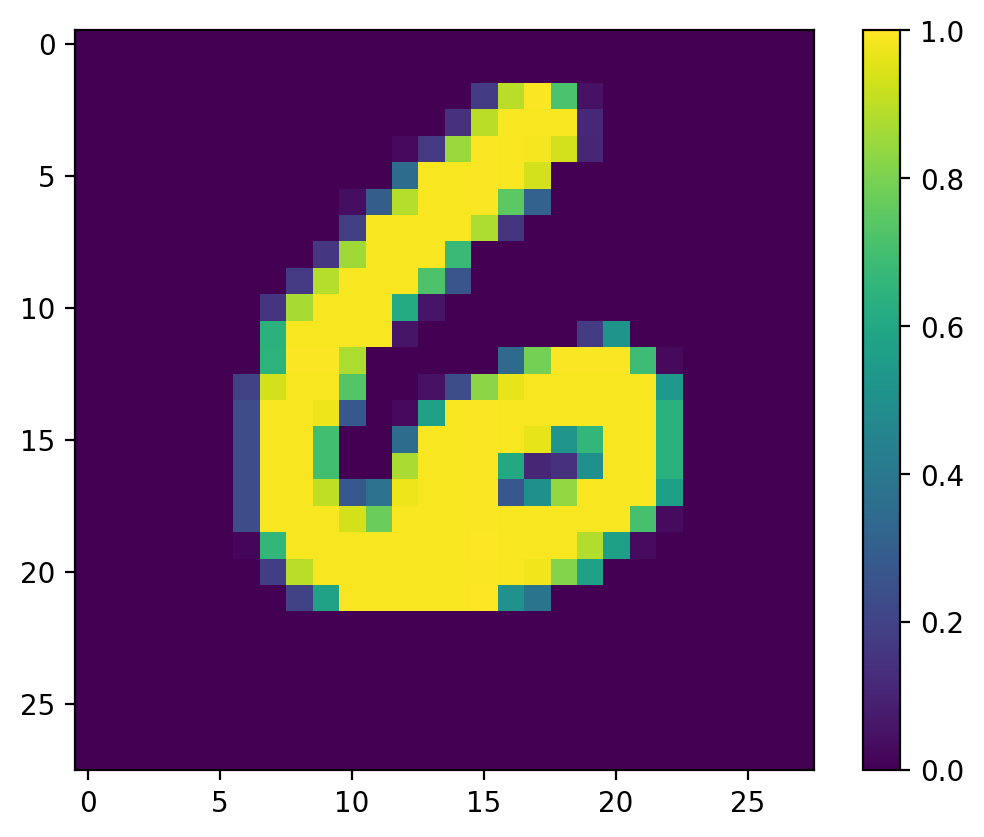

In [7]:
# Representamos una de las imágenes estableciendo un cmap que le de colores

plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

Creamos un conjunto de validación

In [8]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

# Del conjunto de entrenamiento, enviamos 45k imágenes a entrenmiento y dejamos el resto (15k) para validación

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise:** Train an MLP network based on four dense layers of 256, 128, 64 and 10 hidden units respectively. Calculate the accuracy in training and test sets after training only 3 epochs. If you notice overfitting problems, introduce whatever mechanisms you consider to reduce it.

In [9]:
#YOUR CODE HERE

# Creamos un MLP con 3 capas ocultas + una salida (con 10 neuronas ya que contamos con 10 posibles clases)
# Entre capas aplicamos una ReLu (evitamos desvanecimiento de gradiente) y acabamos con una logsoftmax (para clasificación multiclase)

class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [10]:
#YOUR CODE HERE

# Introducimos el entrenamiento, el estudio del conjunto de validación y el análisis del acuraccy

class MLP_extended(MLP):
    # Todo es igual que el regresor logístico multiclase pero añadiendo el número de las neuronas de las capas ocultas
    # Añadimos la dimensión de la capa extra con la que contamos
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # Lista que guarda la evolución de la función de coste en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): # de esta forma ahorra en coste computacional
                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val.view(images_val.shape[0], -1))
                    validation_loss += self.criterion(out_val, labels_val)
                    
                # de esta forma, en cada época, estudiamos el valor de la función de coste sobre todo el conjunto de validación

                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader)) # actualizamos dicho valor en la época correspondiente

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1])) # ploteamos el valor de la función de coste sobre el conjunto de valdación en cada época
                print('')

    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

In [11]:
my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=3, lr=1e-3)
my_MLP.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.361560
Validation loss after 0 epochs: 0.190579

Training loss after 1 epochs: 0.133792
Validation loss after 1 epochs: 0.110809

Training loss after 2 epochs: 0.086551
Validation loss after 2 epochs: 0.107773



In [13]:
# Estudiamos los acuraccy de los diferentes conjuntos de datos

acurracy_train_MLP = my_MLP.acurracy_study(trainloader,my_MLP)
acurracy_test_MLP = my_MLP.acurracy_study(testloader,my_MLP)
acurracy_val_MLP = my_MLP.acurracy_study(validloader,my_MLP)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP))
print('El acurracy en el set de validación es: ' + str(acurracy_val_MLP))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP))

El acurracy en el set de entrenamiento es: 0.9827992
El acurracy en el set de validación es: 0.96866137
El acurracy en el set de test es: 0.9732285


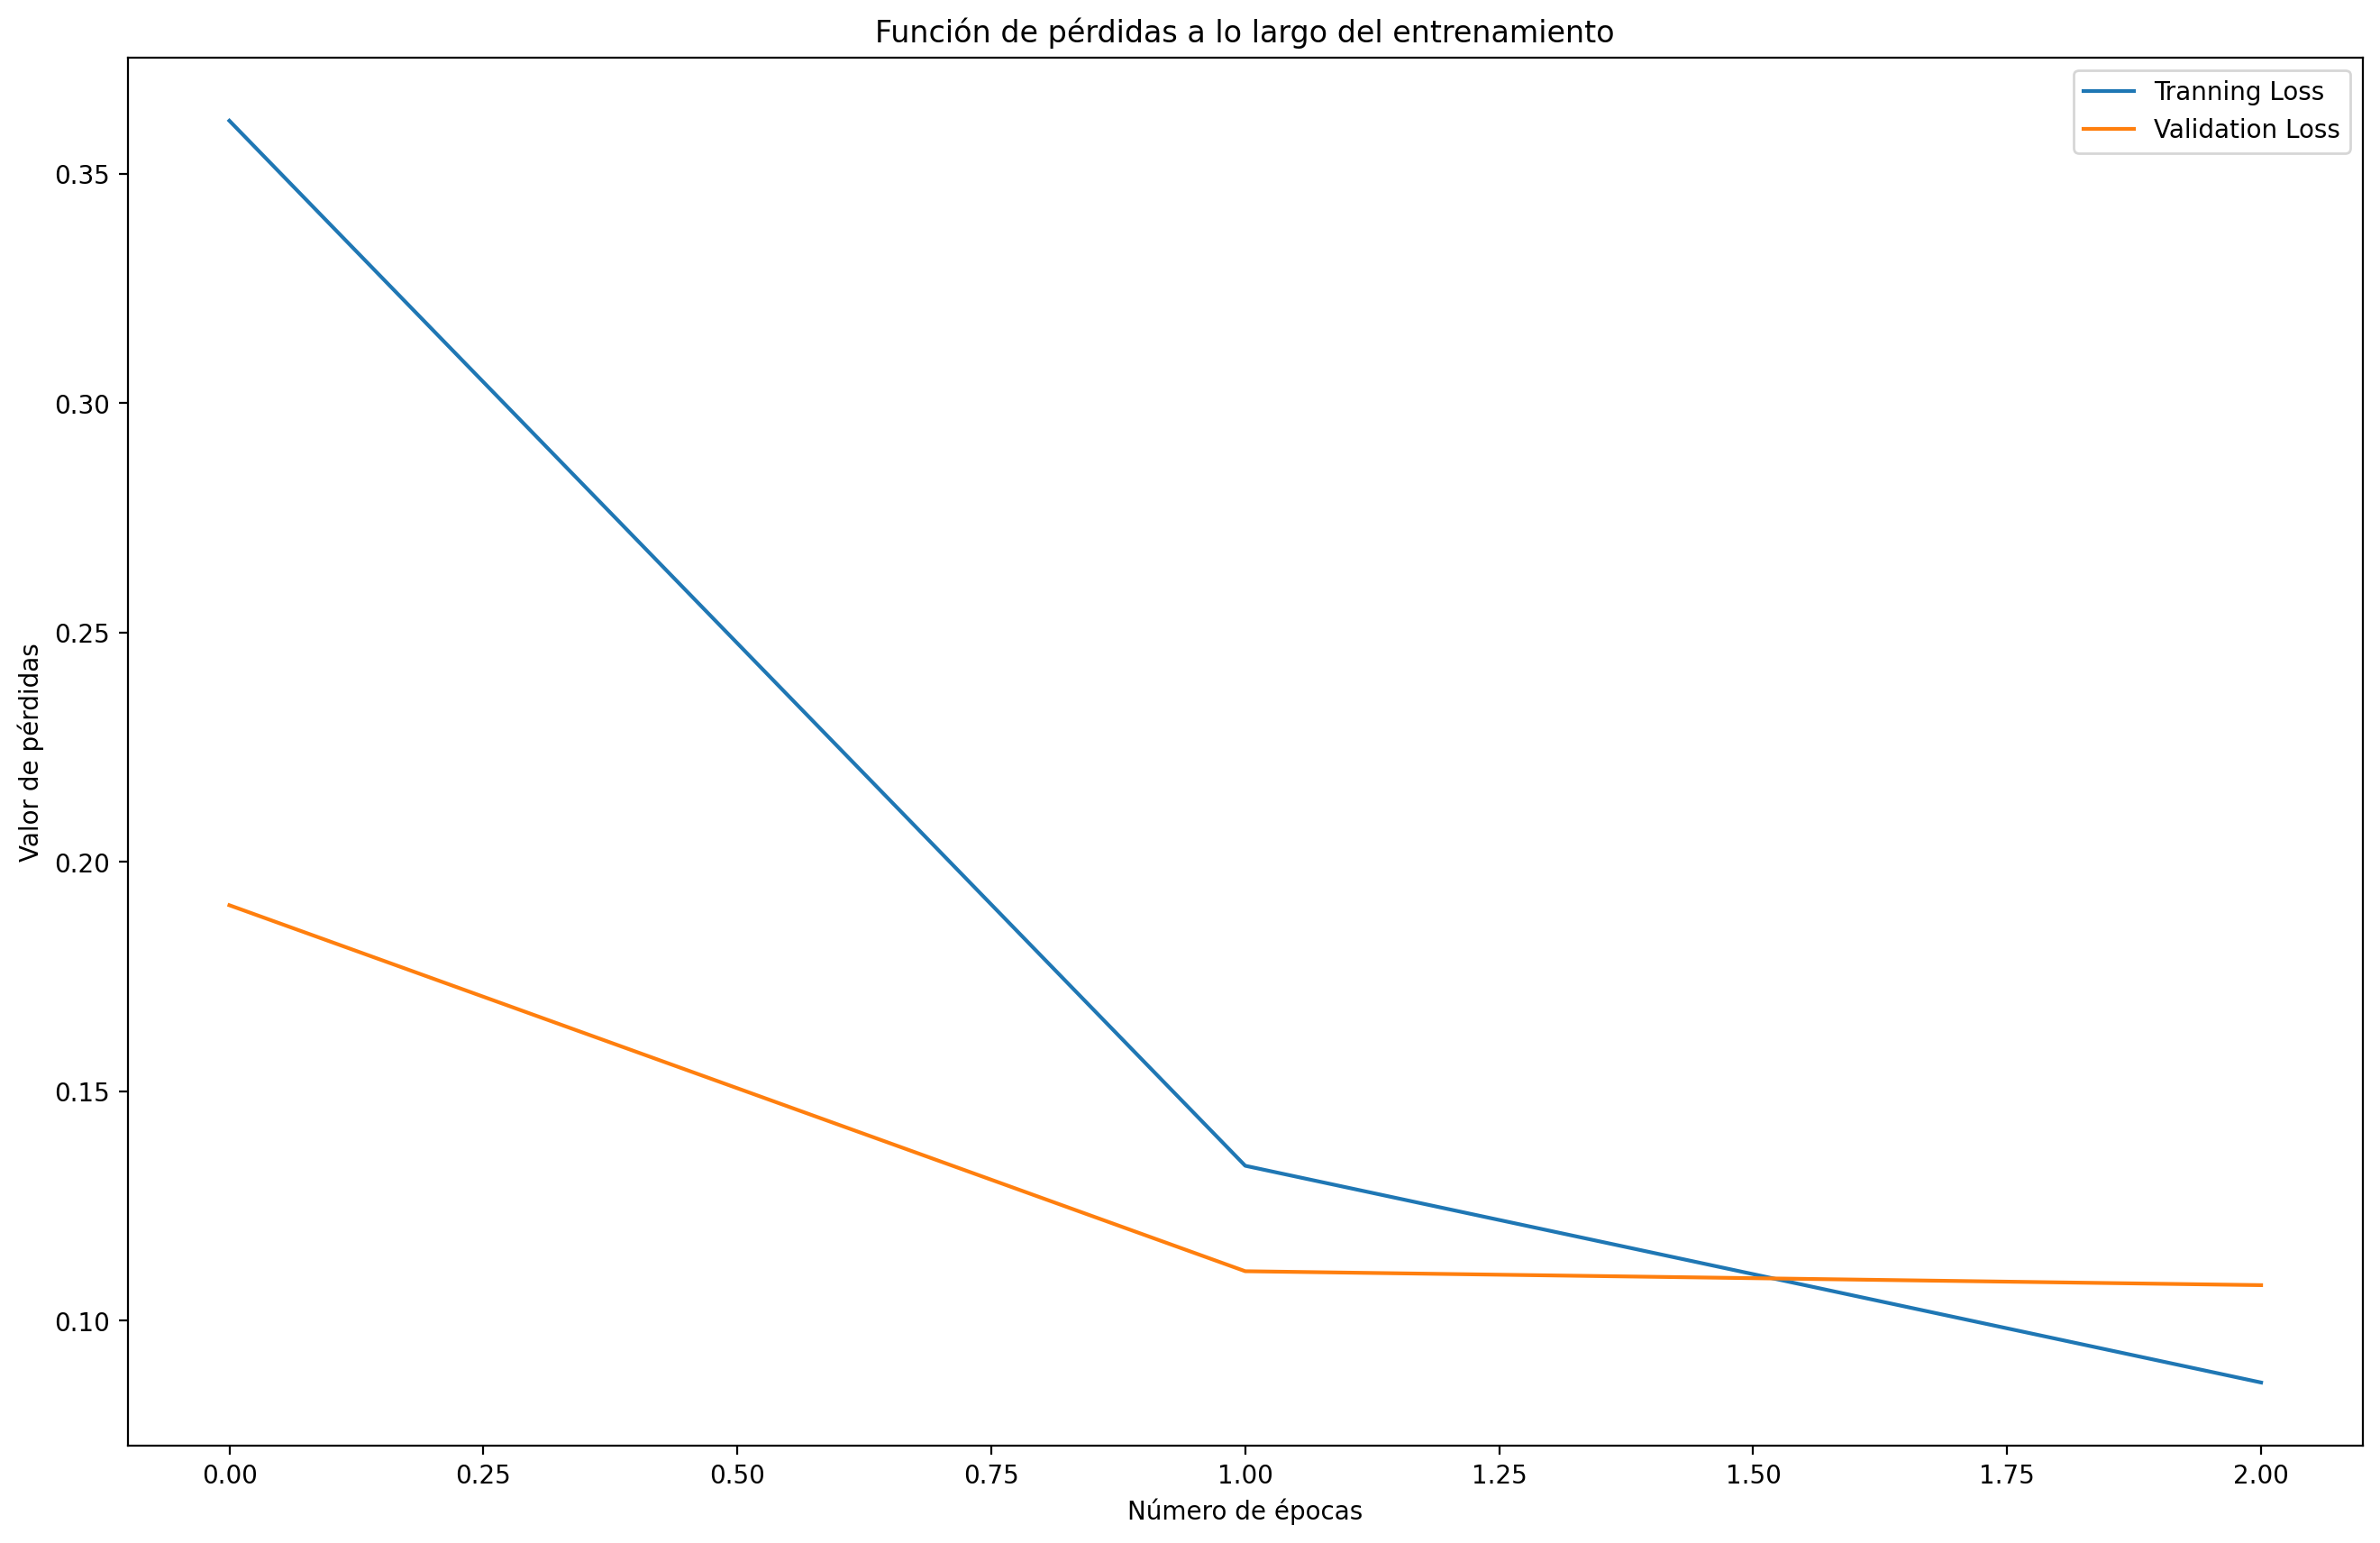

In [14]:
# Ploteamos la función de pérdida de entrenamiento y validación

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(my_MLP.loss_during_training,label='Tranning Loss')
ax.plot(my_MLP.valid_loss_during_training,label='Validation Loss')
ax.set_title('Función de pérdidas a lo largo del entrenamiento')
ax.set_xlabel('Número de épocas')
ax.set_ylabel('Valor de pérdidas')
ax.legend()

Como vemos, aún siendo pocas épocas, a partir de la segunda, el conjunto de validación empieza a mantener un valor constante mientras el conjunto de entrenamiento sigue decreciendo su valor en la función de coste. Esto puede dar indicios de un posible overfitting derivado de utilizar una arquitectura tan densa y compleja para un problema relativamente sencillo. Aplicaremos la ténica del dropout para combatir este fenómeno.

In [15]:
# Añadimos la ténica de dropout

class MLPdrop(nn.Module):
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)

        self.dropout = nn.Dropout(p=p_dropout)   # Introducimos la posibilidad del dropout                                                       
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x) # Tras cada salida, introducimos el dropout
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [16]:
# Entrenamiento, validación y acuraccy junto al dropout

class MLPdrop_extended(MLPdrop):
    # Todo es igual que el regresor logístico multiclase pero añadiendo el número de las neuronas de las capas ocultas
    # Añadimos la dimensión de la capa extra con la que contamos
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,p_dropout)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # Lista que guarda la evolución de la función de coste en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            self.train() # ya que vamos a entrenar el modelo y queremos aplicar dropout

            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): # de esta forma ahorra en coste computacional

                self.eval() # desactivamos el droput para el test del conjunto de evaluación

                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val.view(images_val.shape[0], -1))
                    validation_loss += self.criterion(out_val, labels_val)
                # de esta forma, en cada época, estudiamos el valor de la función de coste sobre todo el conjunto de validación
                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader)) # actualizamos dicho valor en la época correspondiente

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1])) # ploteamos el valor de la función de coste sobre el conjunto de valdación en cada época
                print('')

    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            self.eval()
            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

In [17]:
#YOUR CODE HERE  Utilizamos una p_dropout=0.3

my_MLP_drop = MLPdrop_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=3,lr=1e-3, p_dropout=0.3)
my_MLP_drop.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.503082
Validation loss after 0 epochs: 0.178174

Training loss after 1 epochs: 0.200577
Validation loss after 1 epochs: 0.130022

Training loss after 2 epochs: 0.148766
Validation loss after 2 epochs: 0.113650



In [18]:
# Estudiamos los acuraccy de los diferentes conjuntos de datos

acurracy_train_MLP_drop = my_MLP_drop.acurracy_study(trainloader,my_MLP_drop)
acurracy_test_MLP_drop = my_MLP_drop.acurracy_study(testloader,my_MLP_drop)
acurracy_val_MLP_drop = my_MLP_drop.acurracy_study(validloader,my_MLP_drop)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP_drop))
print('El acurracy en el set de validación es: ' + str(acurracy_val_MLP_drop))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP_drop))

El acurracy en el set de entrenamiento es: 0.97769445
El acurracy en el set de validación es: 0.966711
El acurracy en el set de test es: 0.97034234


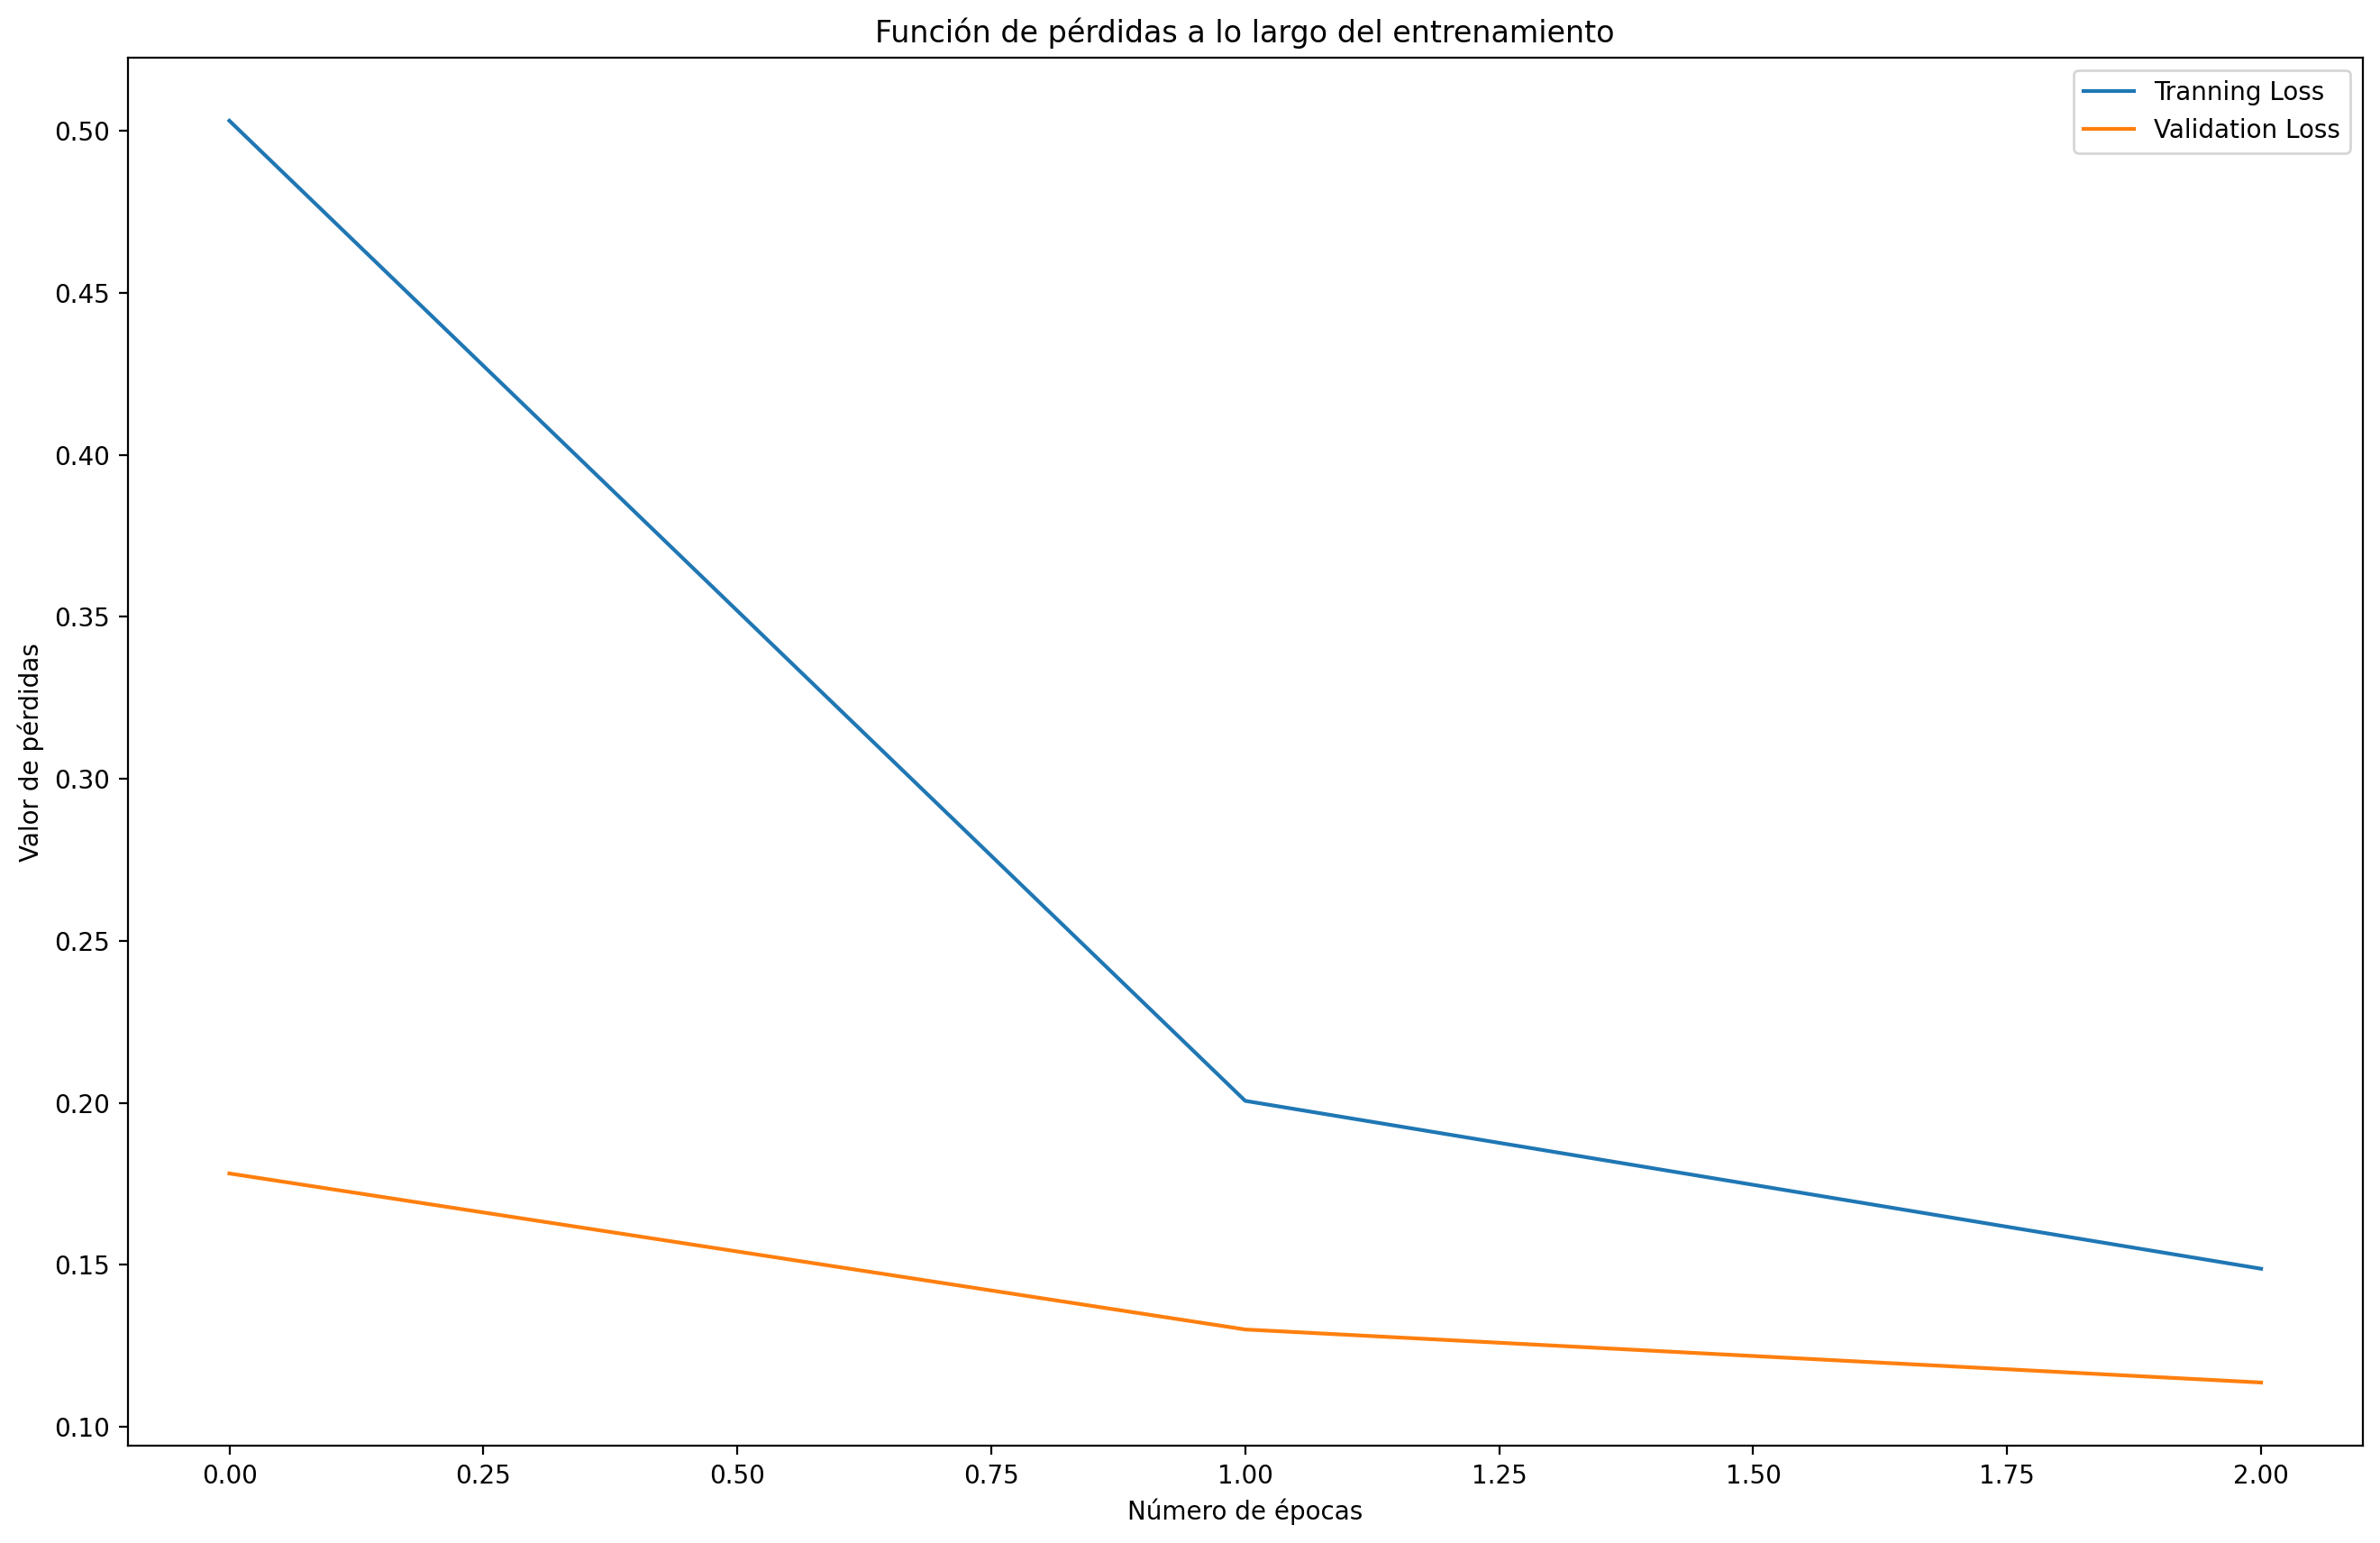

In [19]:
# Ploteamos la función de pérdida de entrenamiento y validación

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(my_MLP_drop.loss_during_training,label='Tranning Loss')
ax.plot(my_MLP_drop.valid_loss_during_training,label='Validation Loss')
ax.set_title('Función de pérdidas a lo largo del entrenamiento')
ax.set_xlabel('Número de épocas')
ax.set_ylabel('Valor de pérdidas')
ax.legend()

Tras aplicar el dropout, podemos observar como, a partir de la época 2 (donde antes comenzaba el overfitting), la función de coste respecto al conjunto de validación sigue decreciendo junto a la función del conjunto de entrenamiento. Esto es una buena indicación de que el modelo no ha sobreaprendido del entrenamiento y aún es capaz de predecir datos ajenos correctamente. Hemos evitado el overfitting.

## Activation Maximization

Once our network has been trained, the goal is to find which features at the input of the network (pixels in our case) are more important for the classifier to decide one class or another at the output. That is, choose between one digit or another at the output. 

The steps we follow are the following:

- We fix the parameters that we have just trained.

- We define a new set of trainable parameters that will emulate the input of the network and we will opbtimize to have a high confidence in a specific digit.

We implement the first step with the following code:

Una vez la red ha sido entrenada y es capaz de clasificar correctamente el conjunto MNIST, buscaremos que variables de entrada a la red (píxeles en este caso) son los más importantes/decisivos para la red en el momento de elegir una clase u otra en la clasificación. Primero fixeamos los parámetros que hemos entrenado y, seguidamente, definimos un nuevo conjunto de parámetros entrenables que emularán la entrada de la red (recordemos que ahora entrenaremos la entrada sobre la salida y su probabilidad de clasificación).

In [20]:
# Desactivamos los gradientes de los parámetros para optimizar el estudio

for param in my_MLP_drop.parameters(): 
    param.requires_grad = False

> **Exercise:** Complete the following code, in which we define the optimization problem to find the image at the input of the network that provides a given confidence in a given digit

In [24]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,NN_trained,lr,img0): 
      
        # NN_trained is the trained network, as argument

        # img0 is a radomn initialization for the input image
        
        super().__init__()
        
        # Self.input --> Image to be optimized

        self.input = nn.Parameter(img0.reshape([1,-1]),requires_grad = True)

        self.NN_trained = NN_trained

        self.lr = lr
        
        # We use mean squared error to minimize the difference between the desired probability and the 
        # obtained for self.input to input

        self.criterion = nn.MSELoss() 

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

        # Tendremos de entrada -> La red entrenada, un learning rate y una imagen puesta de forma aleatoria (tendrá, por tanto, forma de ruido)

    def forward(self):

        # In the forward method we only evaluate the log-probabilities given self.input!

        logprobs = self.NN_trained.forward(self.input) # Establecemos la salida a partir del input (la imágen con ruido); Obtenemos la probabilidad de clf expectada
        
        return logprobs

    def trainloop(self,category,true_prob,sgd_iter):

        # Category is the digit we are going to look at

        # true_prob is the desired probability, which we pass to logarithm
        
        true_log_prob = torch.log(true_prob) # Esta es la probabilidad esperada (a la salida de la red). La pasamos a algoritmo.

        # sgd_iter is the number of iterations , NºIteraciones en busqueda de las variables características de la red
        
        for i in range(sgd_iter):

            # Reset the gradients
            #YOUR CODE HERE 
            self.optim.zero_grad()
            
            # Compute the network output
            #YOUR CODE HERE
            logprobs = self.forward()
            
            # We calculate the difference between the desired probability (true_log_prob) and the obtained one
            # for the digit
            
            loss = self.criterion(logprobs[0,category].view(true_log_prob.shape),true_log_prob) # Estimamos la pérdida comparando la probabilidad deseada con la obtenida
  
            self.loss_during_training.append(loss) # Introducimos el valor de pérdida de cada iteración para representarla gráficamente a posteriori

            # Compute gradients
            #YOUR CODE HERE
            loss.backward()
          

            # Optimize
            #YOUR CODE HERE
            self.optim.step()

Let's instanciate an object of the previous class for a random initialization (independent Gaussian distribution with mean zero and standard deviation 0.01)

In [25]:
opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01) # Introducimos nuestra red entrenada y una imágen de mi set aleatorizada

> **Exercise:** Obtain the probability distribution at the output of the classifier for the chosen initialization. Remember that the classifier uses a `logsoftmax` on output. Discuss the result.

In [31]:
#YOUR CODE HERE
import math
logprobs = opt_input.forward() # Estudiamos la probabilidad que estima nuestra red 

print('Probabilidades estimadas para cada clase: ' + str(logprobs))

top_p, top_class = logprobs.topk(1, dim=1) # Topk toma, de las 10 probabilidades estimadas para cada clase, la más grande

print('')
print('Mayor probabilidad estimada: ' + str(math.exp(top_p[0][0]))) # Probabilidad estimada mayor
print('Clase a la que pertenece dicha probabilidad: ' + str(top_class[0][0])) # Clase que pertenece esa probabilidad estimada con mayor valor

Probabilidades estimadas para cada clase: tensor([[-2.8175, -2.8649, -2.8178, -2.5835, -1.8994, -1.8770, -2.8229, -1.7497,
         -2.8434, -1.8720]], grad_fn=<LogSoftmaxBackward0>)

Mayor probabilidad estimada: 0.17382014508561933
Clase a la que pertenece dicha probabilidad: tensor(7)


Al utilizar la función de activación a la salida "logsoftmax", las probabilidades se devuelven en forma logarítmica (como sabemos, una probabilidad irá de 0 a 1 (sin tomar nunca estos valores al ser puntos asintóticos) y este rango de valores, en forma logarítmica, toma valores negativos (por eso todos los resultados son negativos)). Básicamente, dada la imagen llena de ruido al principio, mi red ha estimado que pertenece a la clase 5.

> **Exercise:**: Optimize the input representation for 50 iterations to obtain 90% confidence in the digit 3. Plot the loss function.

In [32]:
#YOUR CODE HERE
opt_input.trainloop(category = 3 ,true_prob = torch.tensor(0.9),sgd_iter=50)

In [33]:
loss_training = []

for i in range (len(opt_input.loss_during_training)):
    loss_training.append(opt_input.loss_during_training[i].item())

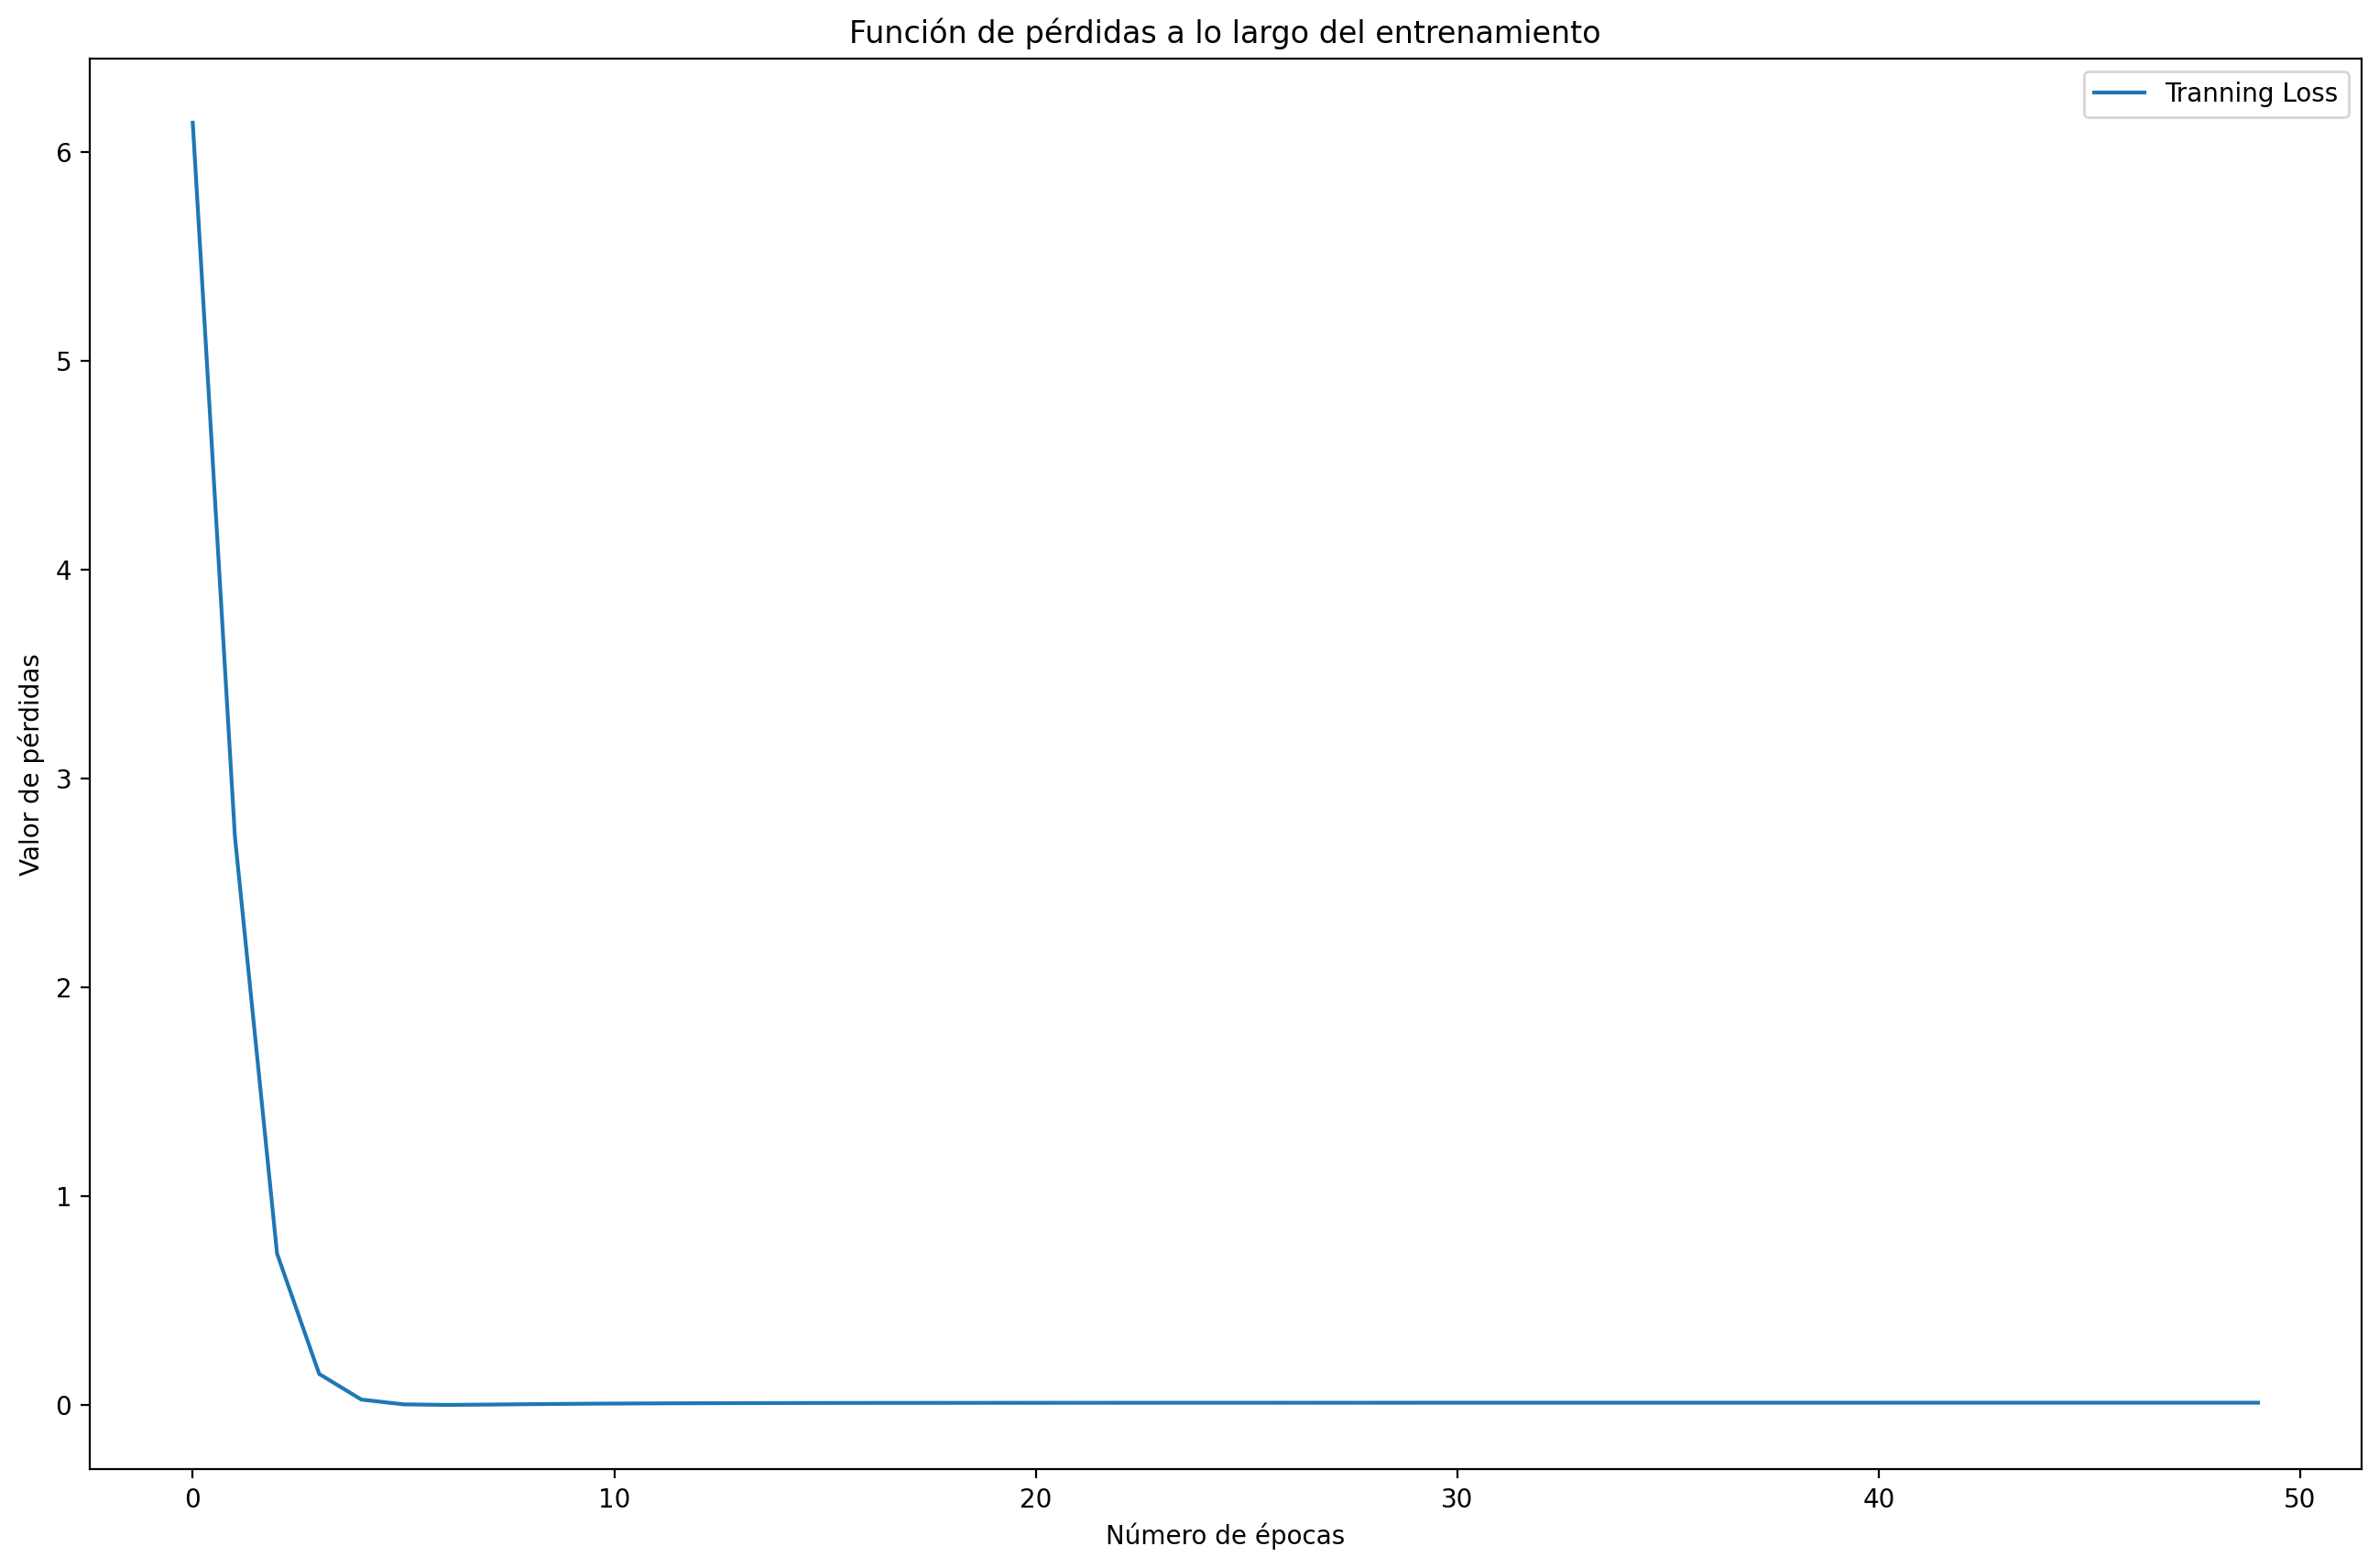

In [34]:
# Ploteamos la función de pérdida de entrenamiento y validación

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(loss_training,label='Tranning Loss')
ax.set_title('Función de pérdidas a lo largo del entrenamiento')
ax.set_xlabel('Número de épocas')
ax.set_ylabel('Valor de pérdidas')
ax.legend()

Como vemos, reducimos encarecidamente el valor de la función de pérdidas para el conjunto de entrenamiento. De esta manera, obtenemos el acuraccy buscado.

> **Exercise:** Compare the probabilities at the output of the classifier before and after optimizing at the input

In [36]:
print('Antes de optimizar:')
print('Mayor probabilidad estimada: ' + str(math.exp(top_p[0][0]))) # Probabilidad estimada mayor
print('Clase a la que pertenece dicha probabilidad: ' + str(top_class[0][0])) # Clase que pertenece esa probabilidad estimada con mayor valor

Antes de optimizar:
Mayor probabilidad estimada: 0.17382014508561933
Clase a la que pertenece dicha probabilidad: tensor(7)


In [37]:
#YOUR CODE HERE
logprobs = opt_input.forward()
top_p, top_class = logprobs.topk(1, dim=1)
print('Después de optimizar:')
print('Mayor probabilidad estimada: ' + str(math.exp(top_p[0][0]))) # Probabilidad estimada mayor
print('Clase a la que pertenece dicha probabilidad: ' + str(top_class[0][0])) # Clase que pertenece esa probabilidad estimada con mayor valor

Después de optimizar:
Mayor probabilidad estimada: 0.9982915552537793
Clase a la que pertenece dicha probabilidad: tensor(3)


Antes de la optimización (con una imágen parecida al ruido), la mayor probabilidad se encontraba en la clase "5". Tras una optimización enfocada a la clase "3" (donde en cada iteración modificamos la imagen de entrada de manera que se parezca a dicho valor), observamos como la predicción de mi red es: Clase 3 con una probabilidad (logarítmica) de -0.0042 (lo que sería prácticamente un 99% en términos lineales). Comprobamos de esta manera que mi entrenamiento funciona correctamente cuando lo enfoco a una clase en concreto.

> **Exercise:** Display the optimized input image. Does it roughly match the expected digit? Discuss the results.

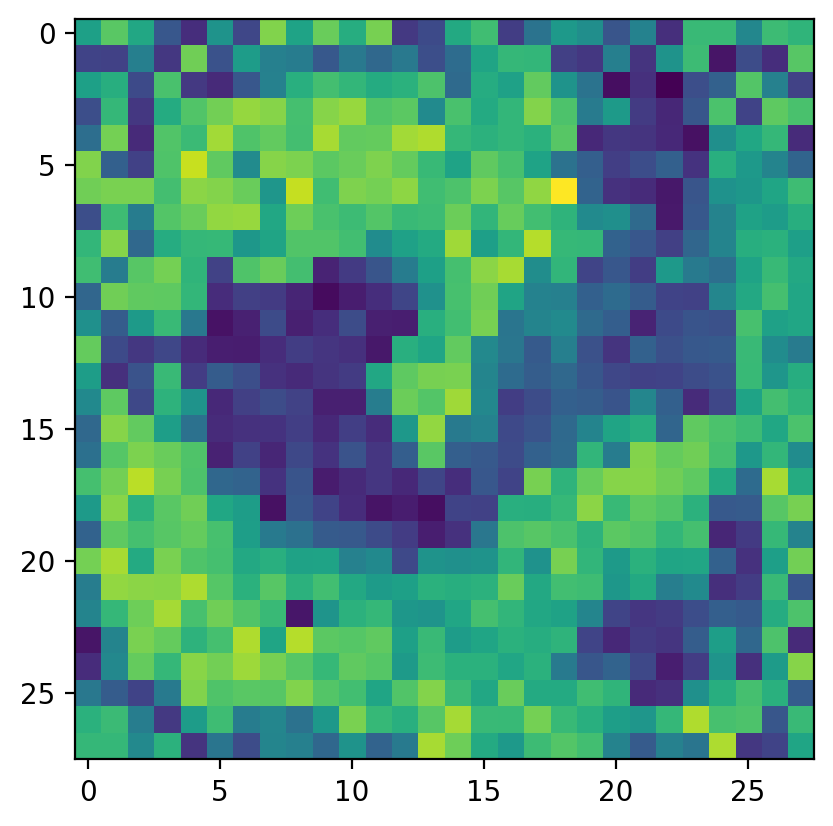

In [38]:
#YOUR CODE HERE
plt.imshow(opt_input.input.detach().numpy().reshape([28,28]))

Analizando la imagen comprobamos rasgos claros del propio número 3. Sin embargo, tampoco somos capaces de diferenciarlo con una gran claridad. Esto se debe a que tampoco hemos utilizado un gran número de iteraciones para obtener dicho valor (por lo que la imagen no ha podido desarrollarse al completo) pero con las establecidas, la red es capaz de encontrar las características clave de dicho valor con el fin de que su probabilidad de predicción incremente de gran manera.

Observemos que ocurre cuando entrenamos la red (por ejemplo enfocada al número 2) con muchas más iteraciones:

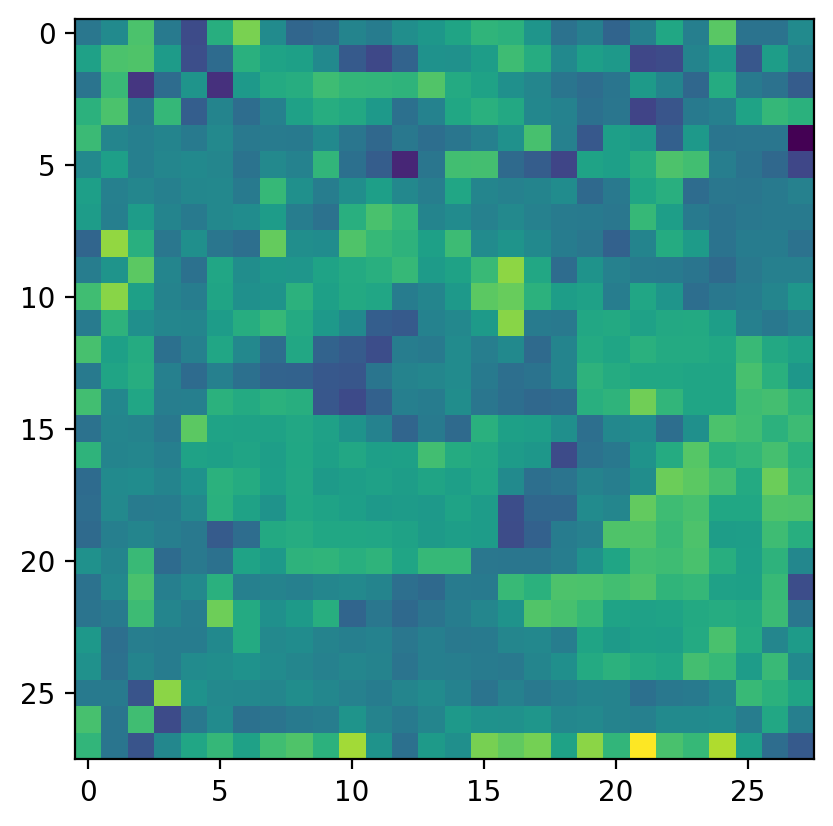

In [39]:
opt_input.trainloop(category = 2 ,true_prob = torch.tensor(0.8),sgd_iter =10000)
plt.imshow(opt_input.input.detach().numpy().reshape([28,28]))

Aquí si que diferenciamos de forma muy sencilla una clara figura representativa del número 2.

> **Exercise:** Repeat the results for all digits and discuss those results.

<Figure size 640x480 with 0 Axes>

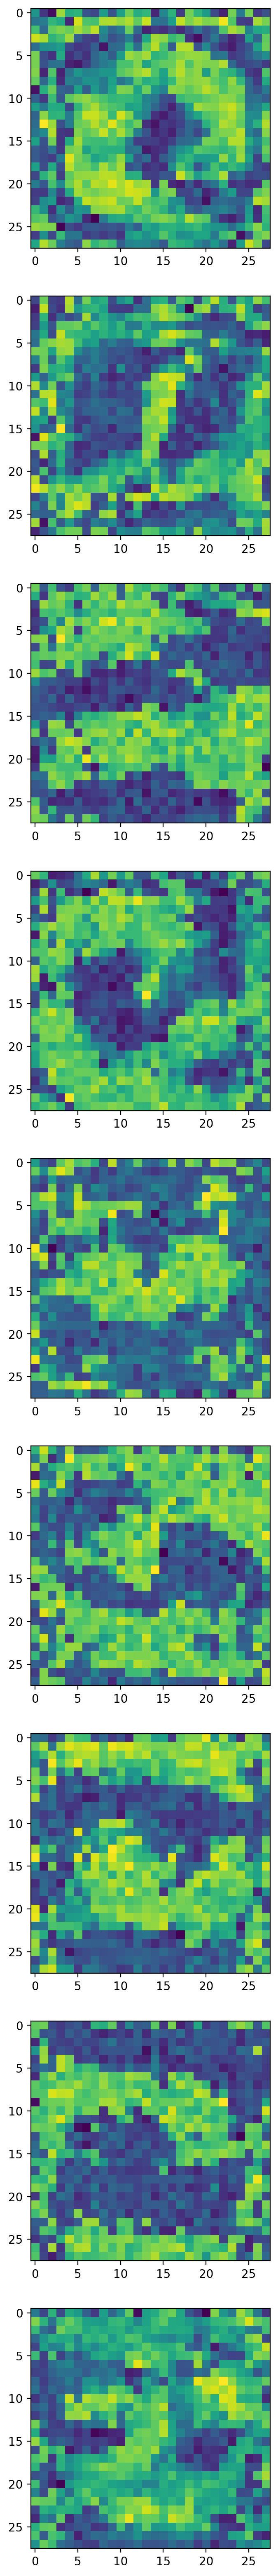

In [42]:
plt.figure()
f, axarr = plt.subplots(9,1, figsize = (40,40)) 

for i in range(9):
    opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01)
    opt_input.trainloop(category = i ,true_prob = torch.tensor(0.8),sgd_iter =50)
    axarr[i].imshow(opt_input.input.detach().numpy().reshape([28,28]))
    

Al igual que en el caso anterior, al utiliar para cada imagen un número relativamente bajo de iteraciones en el entrenamiento, si bien la red es capaz de diferenciar rápido la clase a la que pertenecen, en ciertas imágenes de dificil reconocer patrones que pertenezcan a su número correspondiente.

Para ciertos números en concreto con figuras sencillas (como el 0), ese patrón si se puede reconocer muy rápidemente a la vista.